In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

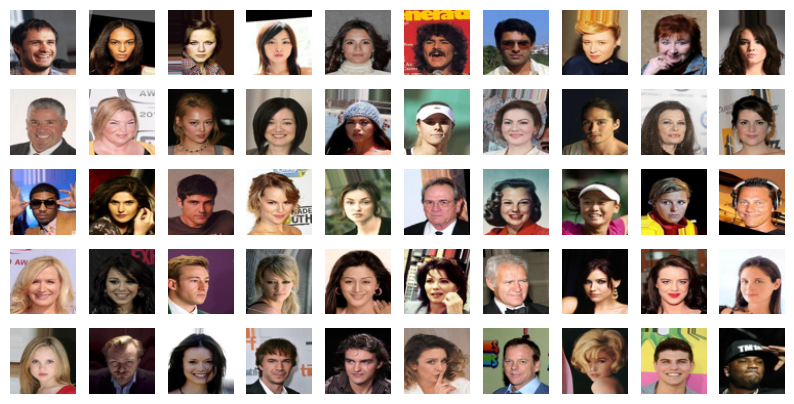

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
cls = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid(),
)

cls(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 1])

In [5]:
class Block(torch.nn.Module):

    def __init__(self, dim_in, dim_out):
        super().__init__()

        def block(dim_in, dim_out, kernel_size=3, stride=1, padding=1):
            return (
                torch.nn.ConvTranspose2d(dim_in,
                                         dim_out,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding),
                torch.nn.BatchNorm2d(dim_out),
                torch.nn.LeakyReLU(),
            )

        self.s = torch.nn.Sequential(
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_out, kernel_size=3, stride=2, padding=0),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
        )

        self.res = torch.nn.ConvTranspose2d(dim_in,
                                            dim_out,
                                            kernel_size=3,
                                            stride=2,
                                            padding=0)

    def forward(self, x):
        return self.s(x) + self.res(x)


gen = torch.nn.Sequential(
    torch.nn.Linear(128, 256 * 4 * 4),
    torch.nn.InstanceNorm1d(256 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
    Block(256, 128),
    Block(128, 64),
    Block(64, 32),
    Block(32, 3),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

gen(torch.randn(2, 128)).shape

torch.Size([2, 3, 64, 64])

In [6]:
def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad_(requires_grad)


criterion = torch.nn.BCELoss()
optimizer_cls = torch.optim.Adam(cls.parameters(), lr=2e-4)
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=2e-4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cls.to(device)
gen.to(device)

cls.train()
gen.train()

device

'cuda'

In [7]:
def train_cls():

    def update(data, label):
        pred = cls(data)
        label = torch.full((64, 1), label, device=device).float()
        loss = criterion(pred, label)

        loss.backward()
        optimizer_cls.step()
        optimizer_cls.zero_grad()

        return loss.item()

    set_requires_grad(cls, True)
    set_requires_grad(gen, False)

    with torch.no_grad():
        data = gen(torch.randn(64, 128, device=device))

    loss_sum = update(data, 0)

    data = next(iter(loader)).to(device)
    loss_sum += update(data, 1)

    return loss_sum


train_cls()

1.4098631143569946

In [8]:
def train_gen():
    set_requires_grad(cls, False)
    set_requires_grad(gen, True)

    pred = cls(gen(torch.randn(64, 128, device=device)))

    loss = criterion(pred, torch.ones(64, 1, device=device))
    loss.backward()
    optimizer_gen.step()
    optimizer_gen.zero_grad()

    return loss.item()


train_gen()

0.6794694066047668

0 1.3847838044166565 0.6813848614692688


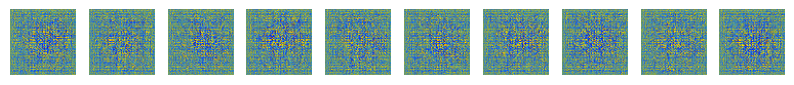

5000 0.44849320501089096 3.9605751037597656


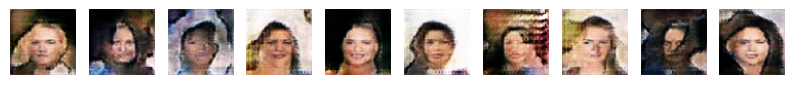

10000 0.21073214709758759 4.280266761779785


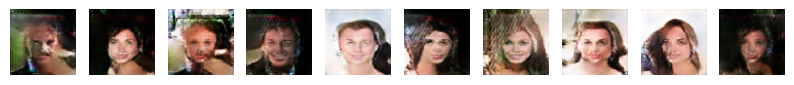

15000 0.546593964099884 4.464622974395752


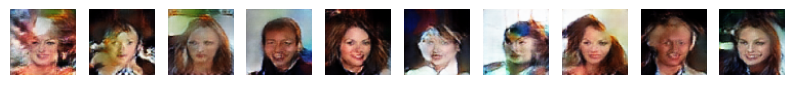

20000 0.2699239030480385 4.052661895751953


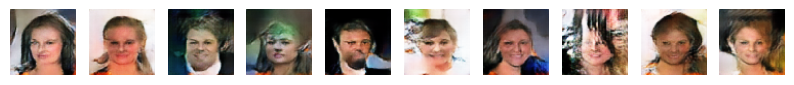

25000 0.33474335074424744 4.444126129150391


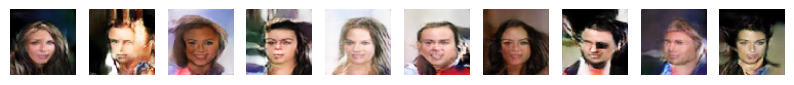

30000 0.2546691745519638 4.330842018127441


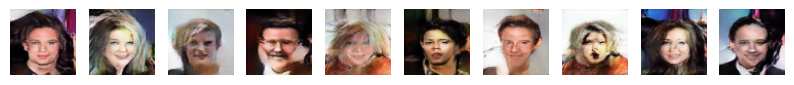

35000 0.24164487421512604 4.297385215759277


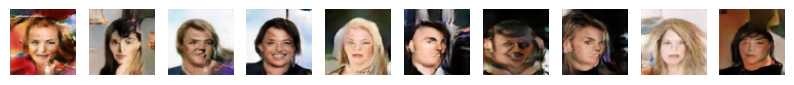

40000 0.26201602816581726 4.993481636047363


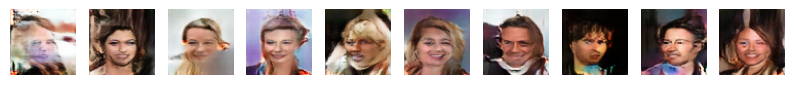

45000 0.3492538332939148 5.3486833572387695


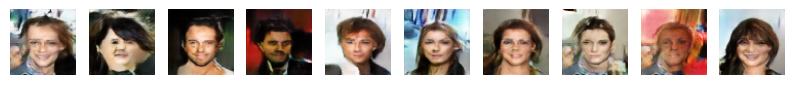

50000 0.12423597276210785 5.181155204772949


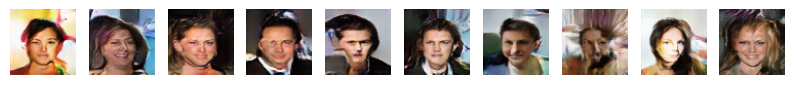

55000 0.249305859208107 4.834295272827148


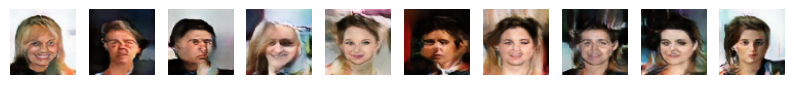

60000 0.35486674308776855 4.778954982757568


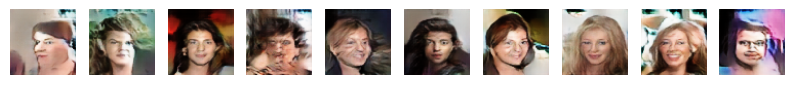

65000 0.30088526755571365 6.045931816101074


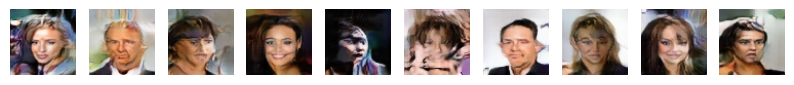

70000 0.23358096182346344 5.101036548614502


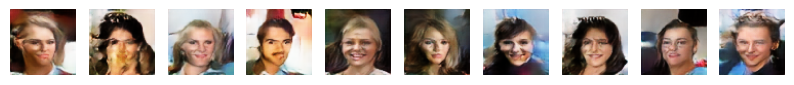

75000 0.3386758342385292 5.102906227111816


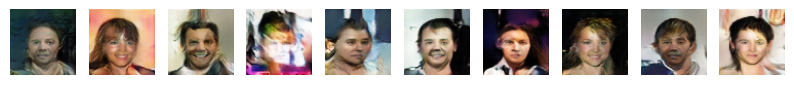

80000 0.23185480758547783 5.473744869232178


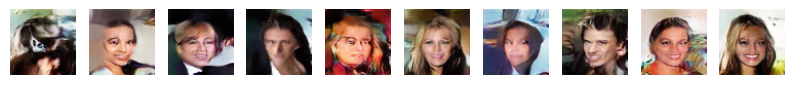

85000 0.2679811865091324 4.952347755432129


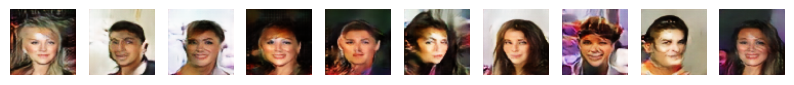

90000 0.17388387024402618 5.8422722816467285


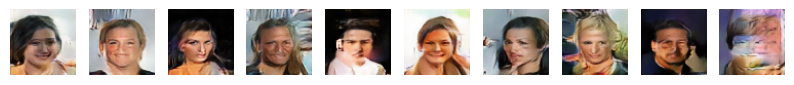

95000 0.22237490862607956 5.145087242126465


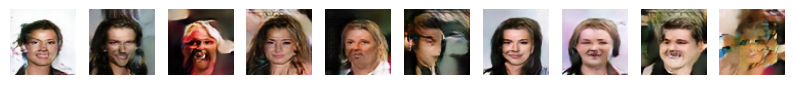

In [9]:
def train():
    for epoch in range(10_0000):
        loss_cls = train_cls()
        loss_gen = train_gen()

        if epoch % 5000 == 0:
            print(epoch, loss_cls, loss_gen)
            with torch.no_grad():
                pred = gen(torch.randn(10, 128, device=device))
            show(pred)


local_training = True

if local_training:
    train()

In [10]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.cls = cls.to('cpu')
        self.gen = gen.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.3.dcgan',
        use_auth_token=open('/root/hub_token.txt').read().strip())

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

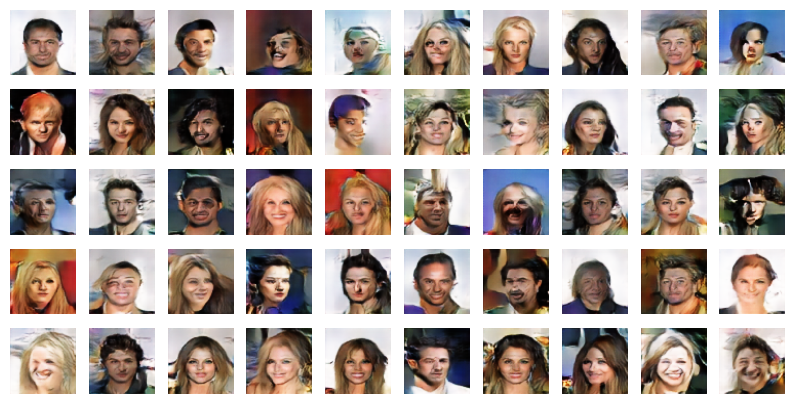

In [11]:
#加载训练好的模型
gen = Model.from_pretrained('lansinuote/gen.3.dcgan').gen

with torch.no_grad():
    pred = gen(torch.randn(50, 128))

show(pred)